## Hometask 3 - 1d cellular automata + code optimization (parallel/vectorized/compiled)

Cellular Automata. Periodic Boundary conditions. (by **Denis Taurenis**, Skoltech 2024)

To implement 1D Cellular Automata (https://en.wikipedia.org/wiki/Rule_110) with periodic boundary conditions, we will use parallelization using MPI unterface. To do it correctly, we will use so-called "ghost nodes" to make correct parallelization. The procedure is presented on the picture.

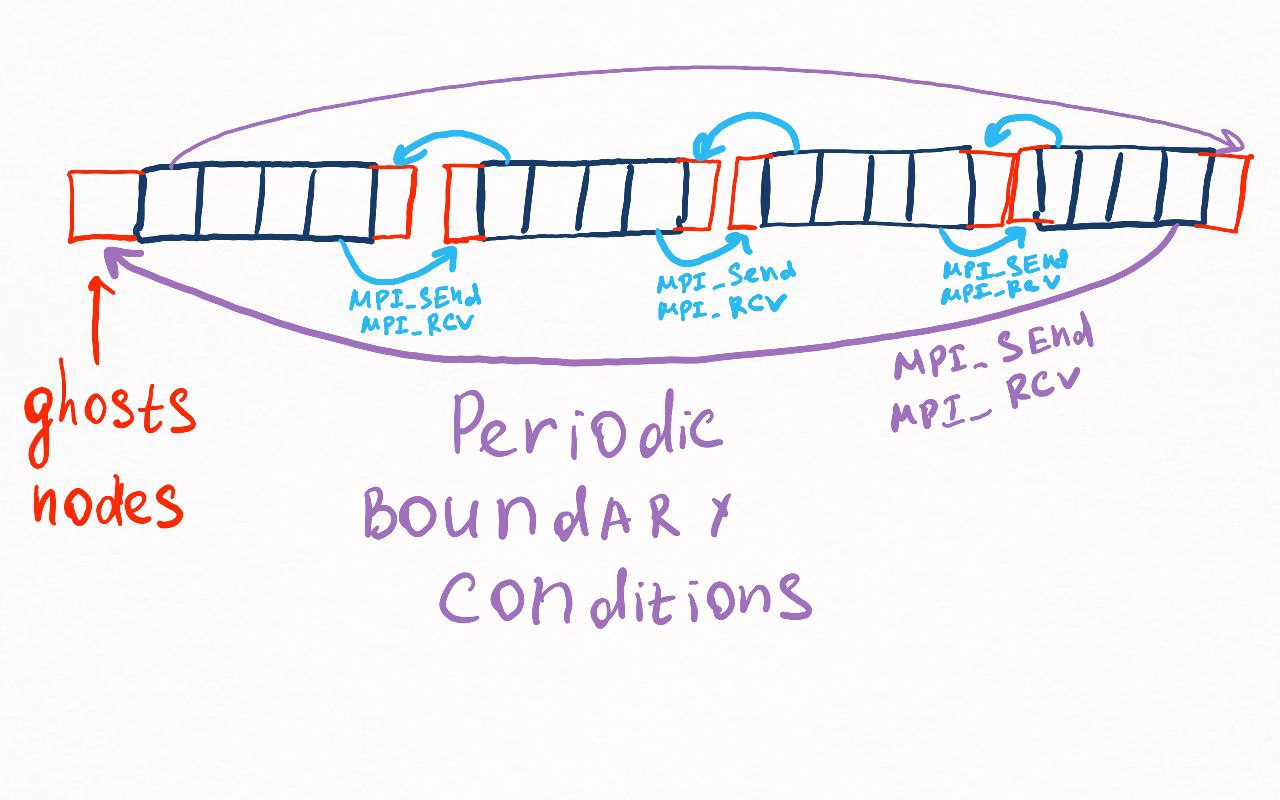

The code will receive the rule in the format of number between 0 and 255. For example, we want to use rule 130. $130 = 10000010_2$. It means that $000 \to 1, 001 \to 0, 010 \to 0, etc.$ Initial conditions will be chosen randomnly.

The code is presented below.

In [1]:
%%writefile cellular_periodic.c

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>


void init_rule(int *rule, int r) {
	for (int i = 7; i >= 0; i--) {
		int denumerator = (1 << i);
		rule[i] = r / denumerator;
		r -= (r / denumerator) * denumerator;
	}
}


int main(int argc, char ** argv)
{
	int r = atoi(argv[1]);
	int rule[8];
	init_rule(rule, r);
	
	int N = (argc < 4) ? 100: atoi(argv[3]); 
	int Nit = (argc < 5) ? 100: atoi(argv[4]); 

	int psize, prank;
	int ierr = MPI_Init(&argc, &argv);
	ierr = MPI_Comm_rank(MPI_COMM_WORLD, &prank);
	ierr = MPI_Comm_size(MPI_COMM_WORLD, &psize);

    MPI_File_delete(argv[2], MPI_INFO_NULL);

    MPI_Barrier(MPI_COMM_WORLD);
    double time_start = MPI_Wtime();

	srand (time(NULL) +  prank);

    MPI_Request request;
    MPI_File fh;
    int rc = MPI_File_open(MPI_COMM_WORLD, argv[2], MPI_MODE_CREATE|MPI_MODE_EXCL|MPI_MODE_WRONLY, MPI_INFO_NULL, &fh);
    int sizeRank = N / psize + ((prank + 1) / (N % psize+1) == 0);

	//Size of the chunk corresponded to the thread
    MPI_Offset offset = sizeRank*prank;
	int sizeRow = sizeRank + 2;
    int charSize = sizeRank + (prank == (psize-1));

    char* buf = (char*)malloc(charSize * sizeof(char));
    if (prank == (psize-1))
        buf[charSize-1] = '\n';
	int* row = (int*)malloc(sizeRow * sizeof(int));
	for(int i = 1; i < sizeRow -1; i++)
		row[i] = rand() % 2;

    int* rowChanged = (int*)malloc(sizeRow * sizeof(int));
	for (int j = 0; j < Nit; j++){
        if (psize > 1)
        {
	        //Boundary conditions
	        if (prank == 0) {
		        MPI_Isend(row+1, 1, MPI_INT, psize-1, 1, MPI_COMM_WORLD, &request);
		        MPI_Isend(row+sizeRow-2, 1, MPI_INT, 1, 0, MPI_COMM_WORLD, &request);
	        } else if (prank == psize - 1) {
		        MPI_Isend(row+1, 1, MPI_INT, psize-2, 1, MPI_COMM_WORLD, &request);
		        MPI_Isend(row+sizeRow-2, 1, MPI_INT, 0, 0, MPI_COMM_WORLD, &request);
	        } else {
		        MPI_Isend(row+1, 1, MPI_INT, prank-1, 1, MPI_COMM_WORLD, &request);
		        MPI_Isend(row+sizeRow-2, 1, MPI_INT, prank + 1, 0, MPI_COMM_WORLD, &request);
	        }

			MPI_Status status;
	        MPI_Recv(row, 1, MPI_INT, MPI_ANY_SOURCE, 0, MPI_COMM_WORLD, &status);
	        MPI_Recv(row + sizeRow - 1, 1, MPI_INT, MPI_ANY_SOURCE, 1, MPI_COMM_WORLD, &status);

		    ierr =  MPI_Barrier(MPI_COMM_WORLD);
        } else {
            row[0] = row[sizeRow-2];
            row[sizeRow-1] = row[1];
        }

	    //On step of the iteration with respect to the chink of the thread
	    for (int i = 1; i < sizeRow - 1; i++){
		    rowChanged[i] = rule[4 * row[i-1] + 2 * row[i] + row[i+1]];
	    }
	    for (int i = 1; i < sizeRow - 1; i++){
		    row[i] = rowChanged[i];
            buf[i-1] = rowChanged[i] +'0';
        }
        
        //write to file
        MPI_File_write_at(fh, offset, buf, charSize, MPI_CHAR, MPI_STATUS_IGNORE);
        offset += N + 1;
            
		ierr =  MPI_Barrier(MPI_COMM_WORLD);
    }
    
    free(row);
    free(buf);
    free(rowChanged);
    
    MPI_File_close(&fh);
    double time_end = MPI_Wtime();
    if (prank == 0)
        printf("MPI_Wtime: %1.4f\n", time_end - time_start);

	ierr = MPI_Finalize();

	return 0;
}

Writing cellular_periodic.c


In [2]:
!mpicc cellular_periodic.c

Let's see results for rules $120, 140,$ and $30$. These are presented in the images below.

In [5]:
from pathlib import Path

import numpy as np


def open_data(path: Path):
    file = path.open()
    data = []
    gr = file.readline().strip()
    while gr:
        gr = [int(x) for x in str(gr)]
        data.append(gr)
        gr = file.readline().strip()
    data = np.array(data)
    return data

MPI_Wtime: 0.0011
MPI_Wtime: 0.0026
MPI_Wtime: 0.0061


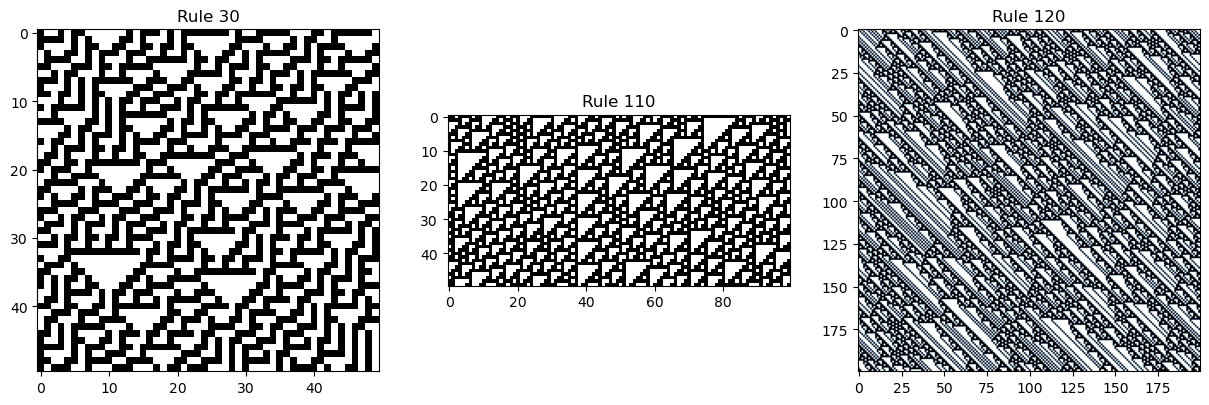

In [6]:
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path


test_sets = [
    {
        'r': 30,
        'n_processes': 1,
        'n_rows': 50,
        'n_cols': 50,
    },
    {
        'r': 110,
        'n_processes': 2,
        'n_rows': 50,
        'n_cols': 100,
    },
    {
        'r': 120,
        'n_processes': 4,
        'n_rows': 200,
        'n_cols': 200,
    }
]

fig, axs = plt.subplots(1, len(test_sets), figsize = (15, 10))
axs = np.array(axs).reshape(-1)
for i, (test_set, ax) in enumerate(zip(test_sets, axs)):
    r = test_set['r']
    path = Path(f"{r}.txt")
    
    subprocess.run([
        'mpirun', 
        '-n', str(test_set['n_processes']), 
        './a.out', 
        str(r), 
        str(path), 
        str(test_set['n_cols']), str(test_set['n_rows'])
    ])
    
    data = open_data(path)
    ax.imshow(data, cmap='bone_r')
    ax.set_title(f"Rule {r}")
    path.unlink()

## Tasks

### 1. Check that the code above works correctly on your system.
### 2. Measure computation times for 1, 2, 4 mpi processes. Can you see the speedup?

In [7]:
%%timeit
!mpirun -n 1 ./a.out 30 30.txt 100000000 10

MPI_Wtime: 5.3444
MPI_Wtime: 5.2983
MPI_Wtime: 6.9120
MPI_Wtime: 6.7706
MPI_Wtime: 5.4984
MPI_Wtime: 5.2828
MPI_Wtime: 6.7054
MPI_Wtime: 5.2487
6.19 s ± 727 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
!mpirun -n 2 ./a.out 30 30.txt 100000000 10

MPI_Wtime: 2.8754
MPI_Wtime: 2.8566
MPI_Wtime: 3.6154
MPI_Wtime: 2.7242
MPI_Wtime: 2.8738
MPI_Wtime: 2.7099
MPI_Wtime: 2.7482
MPI_Wtime: 2.8741
3.15 s ± 293 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
!mpirun -n 4 ./a.out 30 30.txt 100000000 10

MPI_Wtime: 1.8934
MPI_Wtime: 1.6703
MPI_Wtime: 2.1187
MPI_Wtime: 1.9593
MPI_Wtime: 1.4166
MPI_Wtime: 1.8735
MPI_Wtime: 1.6504
MPI_Wtime: 1.7623
2.03 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


3. Try to implement this cellular automata code on Python. Can you make it faster than the C version? You are free to use any tool (not limited by what you learnt during the course). You can also reorganize the code logic.

Напишем вариант без распараллеливания и убедимся, что он работает:

In [10]:
%%writefile cellular_periodic_without_parallel.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>

void init_rule(int *rule, int r) {
    for (int i = 7; i >= 0; i--) {
        int denumerator = (1 << i);
        rule[i] = r / denumerator;
        r -= (r / denumerator) * denumerator;
    }
}

void compute_next_state(int *row, int *rowChanged, int *rule, int sizeRow) {
    for (int i = 1; i < sizeRow - 1; i++) {
        rowChanged[i] = rule[4 * row[i - 1] + 2 * row[i] + row[i + 1]];
    }
}

void update_state(int *row, int *rowChanged, char *buf, int sizeRow) {
    for (int i = 1; i < sizeRow - 1; i++) {
        row[i] = rowChanged[i];
        buf[i - 1] = rowChanged[i] + '0';
    }
}

int main(int argc, char **argv) {
    int r = atoi(argv[1]);
    int rule[8];
    init_rule(rule, r);

    int N = (argc < 4) ? 100 : atoi(argv[3]);
    int Nit = (argc < 5) ? 100 : atoi(argv[4]);

    srand(time(NULL));

    FILE *fh = fopen(argv[2], "w");
    int sizeRow = N + 2;
    int charSize = N + 1;

    char *buf = (char *)malloc(charSize * sizeof(char));
    buf[charSize - 1] = '\n';
    int *row = (int *)malloc(sizeRow * sizeof(int));
    for (int i = 1; i < sizeRow - 1; i++)
        row[i] = rand() % 2;

    int *rowChanged = (int *)malloc(sizeRow * sizeof(int));
    for (int j = 0; j < Nit; j++) {
        row[0] = row[sizeRow - 2];
        row[sizeRow - 1] = row[1];

        compute_next_state(row, rowChanged, rule, sizeRow);
        update_state(row, rowChanged, buf, sizeRow);

        fwrite(buf, sizeof(char), charSize, fh);
    }

    free(row);
    free(buf);
    free(rowChanged);

    fclose(fh);

    return 0;
}

Writing cellular_periodic_without_parallel.c


In [11]:
!mpicc cellular_periodic_without_parallel.c

In [12]:
%%timeit
!mpirun -n 1 ./a.out 30 30.txt 100000000 10

5.63 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


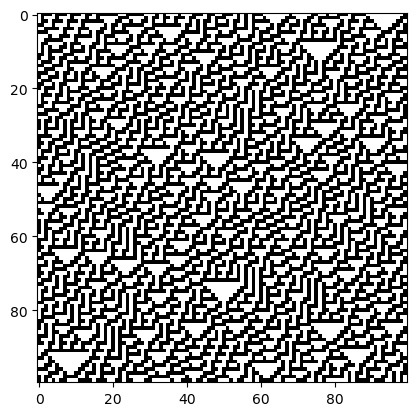

In [13]:
!mpirun -n 1 ./a.out 30 30.txt 100 100

plt.figure()
ax = plt.gca()
path = Path('30.txt')
data = open_data(path)
ax.imshow(data, cmap='bone_r')

In [14]:
%%writefile cellular_periodic_mpi1.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>
#include <mpi.h>

void init_rule(int *rule, int rule_number) {
    for (int i = 7; i >= 0; i--) {
        int denumerator = (1 << i);
        rule[i] = rule_number / denumerator;
        rule_number -= (rule_number / denumerator) * denumerator;
    }
}

void compute_next_state(int *row, int *next_row, int *rule, int row_size, int rank, int size) {
    if (size == 1) {
        for (int i = 1; i < row_size - 1; i++) {
            next_row[i] = rule[4 * row[i - 1] + 2 * row[i] + row[i + 1]];
        }
    } else {
        int local_size = row_size / size;
        int start = rank * local_size + 1;
        int end = (rank == size - 1) ? row_size - 1 : start + local_size;

        for (int i = start; i < end; i++) {
            next_row[i] = rule[4 * row[i - 1] + 2 * row[i] + row[i + 1]];
        }

        if (rank > 0) {
            MPI_Send(&next_row[start], 1, MPI_INT, rank - 1, 0, MPI_COMM_WORLD);
        }
        if (rank < size - 1) {
            MPI_Send(&next_row[end - 1], 1, MPI_INT, rank + 1, 0, MPI_COMM_WORLD);
        }
        if (rank > 0) {
            MPI_Recv(&next_row[start - 1], 1, MPI_INT, rank - 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        }
        if (rank < size - 1) {
            MPI_Recv(&next_row[end], 1, MPI_INT, rank + 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        }
    }
}

void update_state(int *row, int *next_row, char *buf, int row_size, int rank, int size) {
    if (size == 1) {
        for (int i = 1; i < row_size - 1; i++) {
            row[i] = next_row[i];
            buf[i - 1] = next_row[i] + '0';
        }
    } else {
        int local_size = row_size / size;
        int start = rank * local_size + 1;
        int end = (rank == size - 1) ? row_size - 1 : start + local_size;

        for (int i = start; i < end; i++) {
            row[i] = next_row[i];
            buf[i - 1] = next_row[i] + '0';
        }
    }
}

int main(int argc, char **argv) {
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int rule_number = atoi(argv[1]);
    int rule[8];
    init_rule(rule, rule_number);

    int n_columns = (argc < 4) ? 100 : atoi(argv[3]);
    int n_rows = (argc < 5) ? 100 : atoi(argv[4]);

    srand(time(NULL) + rank);

    FILE *fh = fopen(argv[2], "w");
    int local_cells = n_columns / size;
    int row_size = local_cells + 2;
    int buffer_size = local_cells + 1;

    char *buf = (char *)malloc(buffer_size * sizeof(char));
    buf[buffer_size - 1] = '\n';
    int *row = (int *)malloc(row_size * sizeof(int));
    for (int i = 1; i < row_size - 1; i++)
        row[i] = rand() % 2;

    int *next_row = (int *)malloc(row_size * sizeof(int));
    int left_neighbor, right_neighbor;
    if (size == 1) {
        left_neighbor = right_neighbor = rank;
    } else if (rank == 0) {
        left_neighbor = size - 1;
        right_neighbor = rank + 1;
    } else if (rank == size - 1) {
        left_neighbor = rank - 1;
        right_neighbor = 0;
    } else {
        left_neighbor = rank - 1;
        right_neighbor = rank + 1;
    }

    MPI_Request request[4];
    MPI_Status status[4];
    int left_boundary_cell, right_boundary_cell;

    for (int j = 0; j < n_rows; j++) {
        MPI_Isend(&row[1], 1, MPI_INT, left_neighbor, 0, MPI_COMM_WORLD, &request[0]);
        MPI_Isend(&row[row_size - 2], 1, MPI_INT, right_neighbor, 0, MPI_COMM_WORLD, &request[1]);
        MPI_Irecv(&left_boundary_cell, 1, MPI_INT, left_neighbor, 0, MPI_COMM_WORLD, &request[2]);
        MPI_Irecv(&right_boundary_cell, 1, MPI_INT, right_neighbor, 0, MPI_COMM_WORLD, &request[3]);

        row[0] = left_boundary_cell;
        row[row_size - 1] = right_boundary_cell;

        MPI_Waitall(4, request, status);

        compute_next_state(row, next_row, rule, row_size, rank, size);
        update_state(row, next_row, buf, row_size, rank, size);

        if (rank == 0) {
            fwrite(buf, sizeof(char), buffer_size, fh);
        }
    }

    if (size > 1 && rank != 0) {
        MPI_Send(buf, buffer_size, MPI_CHAR, 0, 0, MPI_COMM_WORLD);
    } else if (size > 1) {
        fwrite(buf, sizeof(char), buffer_size, fh);
        for (int i = 1; i < size; i++) {
            MPI_Recv(buf, buffer_size, MPI_CHAR, i, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            fwrite(buf, sizeof(char), buffer_size, fh);
        }
    }

    free(row);
    free(buf);
    free(next_row);

    fclose(fh);

    MPI_Finalize();

    return 0;
}


Writing cellular_periodic_mpi1.c


In [15]:
!mpicc cellular_periodic_mpi1.c

In [16]:
%%timeit
!mpirun -n 1 ./a.out 30 30.txt 100000000 10

5.86 s ± 373 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
!mpirun -n 2 ./a.out 30 30.txt 100000000 10

1.93 s ± 91.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
!mpirun -n 4 ./a.out 30 30.txt 100000000 10

933 ms ± 83.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
!mpirun -n 1 ./a.out 30 30.txt 100 100

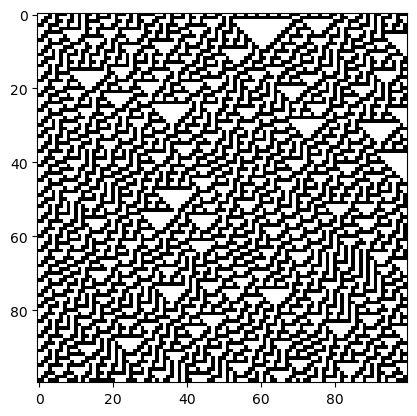

In [20]:
plt.figure()
ax = plt.gca()
path = Path('30.txt')
data = open_data(path)
ax.imshow(data, cmap='bone_r')

Вариация на python:

In [21]:
%%writefile cellular_periodic_python.py

import numpy as np
import random
import sys
import time
from numba import njit


def init_rule(rule_number):
    rule = np.zeros(8, dtype=np.int32)
    for i in range(7, -1, -1):
        denumerator = (1 << i)
        rule[i] = rule_number // denumerator
        rule_number -= (rule_number // denumerator) * denumerator
    return rule


def compute_next_state(row, next_row, rule, row_size):
    for i in range(1, row_size - 1):
        next_row[i] = rule[4 * row[i - 1] + 2 * row[i] + row[i + 1]]


def update_state(row, next_row, buf, row_size):
    for i in range(1, row_size - 1):
        row[i] = next_row[i]
        buf[i - 1] = next_row[i] + ord('0')


if __name__ == '__main__':
    rule_number = int(sys.argv[1])
    start = time.time()
    rule = init_rule(rule_number)
    
    N = 100 if len(sys.argv) < 4 else int(sys.argv[3])
    Nit = 100 if len(sys.argv) < 5 else int(sys.argv[4])

    random.seed()
    
    fh = open(sys.argv[2], "w")
    row_size = N + 2
    buffer_size = N + 1
    
    buf = np.zeros(buffer_size, dtype=np.int32)
    buf[buffer_size - 1] = ord('\n')
    row = np.zeros(row_size, dtype=np.int32)
    
    row[1:-1] = [random.randint(0, 1) for _ in range(N)]
    
    next_row = np.zeros(row_size, dtype=np.int32)
    
    for j in range(Nit):
        row[0] = row[row_size - 2]
        row[row_size - 1] = row[1]
    
        compute_next_state(row, next_row, rule, row_size)
        update_state(row, next_row, buf, row_size)
    
        fh.write(''.join(chr(c) for c in buf))
    
    fh.close()

Writing cellular_periodic_python.py


In [22]:
%%timeit
!python cellular_periodic_python.py 90 30.txt 100000 10

3.69 s ± 88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


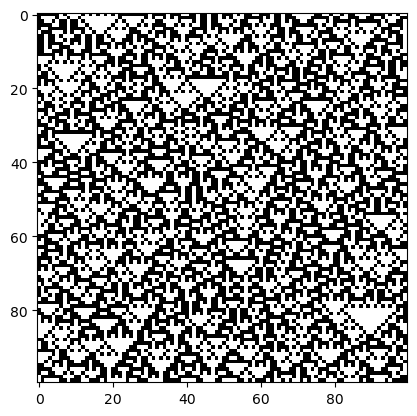

In [23]:
!python cellular_periodic_python.py 90 30.txt 100 100

plt.figure()
ax = plt.gca()
path = Path('30.txt')
data = open_data(path)
ax.imshow(data, cmap='bone_r')

In [24]:
%%writefile cellular_periodic_python_numba_1.py

import numpy as np
import random
import sys
import time
from numba import njit


def init_rule(rule_number):
    rule = np.zeros(8, dtype=np.int32)
    for i in range(7, -1, -1):
        denumerator = (1 << i)
        rule[i] = rule_number // denumerator
        rule_number -= (rule_number // denumerator) * denumerator
    return rule


@njit
def compute_next_state(row, next_row, rule, row_size):
    for i in range(1, row_size - 1):
        next_row[i] = rule[4 * row[i - 1] + 2 * row[i] + row[i + 1]]


@njit
def update_state(row, next_row, buf, row_size):
    for i in range(1, row_size - 1):
        row[i] = next_row[i]
        buf[i - 1] = next_row[i] + ord('0')


if __name__ == '__main__':
    rule_number = int(sys.argv[1])
    start = time.time()
    rule = init_rule(rule_number)
    
    N = 100 if len(sys.argv) < 4 else int(sys.argv[3])
    Nit = 100 if len(sys.argv) < 5 else int(sys.argv[4])

    random.seed()
    
    fh = open(sys.argv[2], "w")
    row_size = N + 2
    buffer_size = N + 1
    
    buf = np.zeros(buffer_size, dtype=np.int32)
    buf[buffer_size - 1] = ord('\n')
    row = np.zeros(row_size, dtype=np.int32)
    
    row[1:-1] = [random.randint(0, 1) for _ in range(N)]
    
    next_row = np.zeros(row_size, dtype=np.int32)
    
    for j in range(Nit):
        row[0] = row[row_size - 2]
        row[row_size - 1] = row[1]
    
        compute_next_state(row, next_row, rule, row_size)
        update_state(row, next_row, buf, row_size)
    
        fh.write(''.join(chr(c) for c in buf))
    
    fh.close()

Writing cellular_periodic_python_numba_1.py


In [25]:
%%timeit
!python cellular_periodic_python_numba_1.py 90 30.txt 100000 10

1.07 s ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


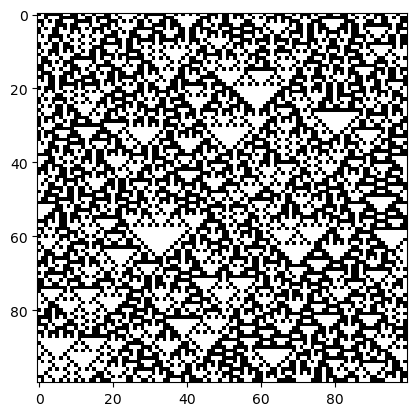

In [26]:
!python cellular_periodic_python_numba_1.py 90 30.txt 100 100

plt.figure()
ax = plt.gca()
path = Path('30.txt')
data = open_data(path)
ax.imshow(data, cmap='bone_r')

In [67]:
%%writefile cellular_periodic_python_numba_2.py

import numpy as np
import random
import sys
import time
from numba import njit


def init_rule(rule_number):
    rule = np.zeros(8, dtype=np.int32)
    for i in range(7, -1, -1):
        denumerator = (1 << i)
        rule[i] = rule_number // denumerator
        rule_number -= (rule_number // denumerator) * denumerator
    return rule


@njit
def compute_next_state_and_update_state(row, next_row, buf, rule, row_size):
    for i in range(1, row_size - 1):
        next_row[i] = rule[4 * row[i - 1] + 2 * row[i] + row[i + 1]]
    for i in range(1, row_size - 1):
        row[i] = next_row[i]
        buf[i - 1] = next_row[i] + ord('0')


if __name__ == '__main__':
    rule_number = int(sys.argv[1])
    start = time.time()
    rule = init_rule(rule_number)
    
    N = 100 if len(sys.argv) < 4 else int(sys.argv[3])
    Nit = 100 if len(sys.argv) < 5 else int(sys.argv[4])

    random.seed()
    
    fh = open(sys.argv[2], "w")
    row_size = N + 2
    buffer_size = N + 1
    
    buf = np.zeros(buffer_size, dtype=np.int32)
    buf[buffer_size - 1] = ord('\n')
    row = np.zeros(row_size, dtype=np.int32)
    
    row[1:-1] = [random.randint(0, 1) for _ in range(N)]
    
    next_row = np.zeros(row_size, dtype=np.int32)
    
    for j in range(Nit):
        row[0] = row[row_size - 2]
        row[row_size - 1] = row[1]

        compute_next_state_and_update_state(row, next_row, buf, rule, row_size)
        
        fh.write(''.join(chr(c) for c in buf))
            
    fh.close()

Overwriting cellular_periodic_python_numba_2.py


In [68]:
%%timeit
!python cellular_periodic_python_numba_2.py 90 30.txt 100000 1

847 ms ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


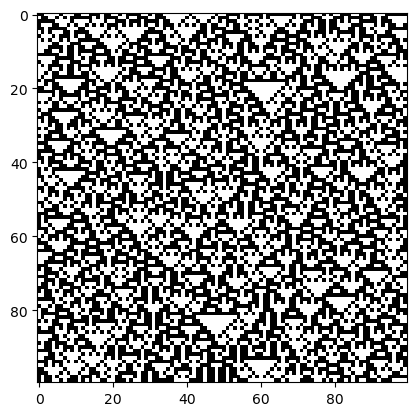

In [69]:
!python cellular_periodic_python_numba_2.py 90 30.txt 100 100

plt.figure()
ax = plt.gca()
path = Path('30.txt')
data = open_data(path)
ax.imshow(data, cmap='bone_r')

Вывод: для данной задачи не получилось прийти к сопоставимому ускорению.

### 4. Can you make bifurcation map task from hw1 any faster? You are also free to use anything that you learnt so far during the course.


#### Без оптимизаций:

In [118]:
def bifurcation_map(r: float, n: int, m: int, initial_x: float = 0.7) -> np.ndarray:
    x = np.zeros(n + m)
    x[0] = initial_x

    for i in range(n + m - 1):
        x[i + 1] = r * x[i] * (1 - x[i])

    return x[n:]

In [126]:
%%timeit
bifurcation_map(0.01, 1000000, 1000000)

15.3 s ± 636 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Numba:

In [141]:
import numba

@numba.njit()
def bifurcation_map(r: float, n: int, m: int, initial_x: float = 0.7) -> np.ndarray:
    x = np.zeros(n + m)
    x[0] = initial_x

    for i in range(n + m - 1):
        x[i + 1] = r * x[i] * (1 - x[i])

    return x[n:]

In [142]:
%%timeit
bifurcation_map(0.01, 1000000, 1000000)

7.52 ms ± 48.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Concurent features (данных в 10 раз меньше подается для замера времени):

In [131]:
import concurrent.futures
import numpy as np


def calculate_x(r, x):
    return r * x * (1 - x)


def bifurcation_map(r: float, n: int, m: int, initial_x: float = 0.7) -> np.ndarray:
    x = np.zeros(n + m)
    x[0] = initial_x

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(calculate_x, r, x[i]) for i in range(n + m - 1)]
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            x[i + 1] = future.result()

In [132]:
%%timeit
bifurcation_map(0.01, 100000, 100000)

1.29 s ± 9.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multiprocessing (операции проводятся через файл, так как в простой ячейке ноутбука вызов функции bifurcation_map не был возможен):

In [25]:
%%writefile bifurcation_map_multiprocessing.py

import argparse
import multiprocessing
import time
import numpy as np


def calculate_x(args):
    r, x = args
    return r * x * (1 - x)


def bifurcation_map(r: float, n: int, m: int, initial_x: float = 0.7) -> np.ndarray:
    x = np.zeros(n + m)
    x[0] = initial_x

    with multiprocessing.Pool() as pool:
        args = [(r, x[i]) for i in range(n + m - 1)]
        results = pool.map(calculate_x, args)
        for i, result in enumerate(results):
            x[i + 1] = result

    return x[n:]


def main():
    parser = argparse.ArgumentParser(description='Calculate the bifurcation map for a given value of r.')
    parser.add_argument('r', type=float, help='the value of r')
    parser.add_argument('n', type=int, help='the number of iterations to discard')
    parser.add_argument('m', type=int, help='the number of iterations to keep')
    parser.add_argument('--initial_x', type=float, default=0.7, help='the initial value of x')

    args = parser.parse_args()

    start_time = time.time()
    bifurcation_map(args.r, args.n, args.m, args.initial_x)
    end_time = time.time()
    print(end_time - start_time)


if __name__ == '__main__':
    main()


Writing bifurcation_map_multiprocessing.py


In [134]:
!python bifurcation_map.py 3.5 1000000 1000000 --initial_x 0.5

3.637101173400879


Много из заявленного времени уходит на создание пула.

#### Threading (данных в 10 раз меньше для замеров времени):

In [135]:
import threading
import numpy as np


def calculate_x(r, x, i):
    x[i + 1] = r * x[i] * (1 - x[i])


def bifurcation_map(r: float, n: int, m: int, initial_x: float = 0.7) -> np.ndarray:
    x = np.zeros(n + m)
    x[0] = initial_x

    threads = []
    for i in range(n + m - 1):
        thread = threading.Thread(target=calculate_x, args=(r, x, i))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    return x[n:]

In [136]:
%%timeit
bifurcation_map(0.01, 100000, 100000)

6.8 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 5. Same as step 4 but for Julia set task.

#### Вариант без ускорения:

In [147]:
import numpy as np


def julia(z_0: complex, c: complex = 1, n_iterations: int = 20, max_magnitude: float = 1e3) -> int:
    z = z_0
    for i in range(n_iterations):
        z = z**2 + c
        if np.isnan(z.real) or np.isnan(z.imag) or abs(z) > max_magnitude:
            return i
    return n_iterations


def julia_set(c, extent=[-2, 2, -1.5, 1.5], resolution=0.01):
    W = int(abs(extent[1] - extent[0])/resolution)+1
    H = int(abs(extent[2] - extent[3])/resolution)+1
    img = np.empty((H, W))
    for i, x in enumerate(np.linspace(extent[0], extent[1], W)):
        for j, y in enumerate(np.linspace(extent[2], extent[3], H)):
            z_0 = complex(x, y)
            img[j, i] = julia(z_0, c)
    return img

In [8]:
%%timeit
a = julia_set(1)

76.2 ms ± 35.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Numba:

In [23]:
import numpy as np
import numba


@numba.njit
def julia(z_0: complex, c: complex = 1, n_iterations: int = 20, max_magnitude: float = 1e3) -> int:
    z = z_0
    for i in range(n_iterations):
        z = z**2 + c
        if np.isnan(z.real) or np.isnan(z.imag) or abs(z) > max_magnitude:
            return i
    return n_iterations


@numba.njit
def julia_set(c, extent=np.array([-2, 2, -1.5, 1.5]), resolution=0.01):
    W = int(abs(extent[1] - extent[0])/resolution) + 1
    H = int(abs(extent[2] - extent[3])/resolution) + 1
    
    img = np.empty((H, W))
    for i, x in enumerate(np.linspace(extent[0], extent[1], W)):
        for j, y in enumerate(np.linspace(extent[2], extent[3], H)):
            z_0 = complex(x, y)
            img[j, i] = julia(z_0, c)
    return img

In [24]:
%%timeit
a = julia_set(1)

2.86 ms ± 534 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%%writefile julia_set_multiprocessing.py

import numba
import numpy as np
import multiprocessing
import argparse
import time


def julia(z_0: complex, c: complex = 1, n_iterations: int = 20, max_magnitude: float = 1e3) -> int:
    z = z_0
    for i in range(n_iterations):
        z = z**2 + c
        if np.isnan(z.real) or np.isnan(z.imag) or abs(z) > max_magnitude:
            return i
    return n_iterations


def calculate_row(args):
    c, extent, resolution, j = args
    W = int(abs(extent[1] - extent[0])/resolution)+1
    row = np.empty(W)
    for i, x in enumerate(np.linspace(extent[0], extent[1], W)):
        z_0 = complex(x, extent[2] + j * resolution)
        row[i] = julia(z_0, c)
    return row


def julia_set(c, extent=[-2, 2, -1.5, 1.5], resolution=0.01):
    W = int(abs(extent[1] - extent[0])/resolution)+1
    H = int(abs(extent[2] - extent[3])/resolution)+1
    img = np.empty((H, W))

    with multiprocessing.Pool(4) as pool:
        args = [(c, extent, resolution, j) for j in range(H)]
        rows = pool.map(calculate_row, args)
        for j, row in enumerate(rows):
            img[j, :] = row

    return img


def main():
    parser = argparse.ArgumentParser(description='Calculate the Julia set for a given complex number.')
    parser.add_argument('c', type=complex, help='the complex number c')
    parser.add_argument('--extent', type=float, nargs=4, default=[-2, 2, -1.5, 1.5], help='the extent of the image')
    parser.add_argument('--resolution', type=float, default=0.01, help='the resolution of the image')

    args = parser.parse_args()

    start_time = time.time()
    img = julia_set(args.c, args.extent, args.resolution)
    end_time = time.time()

    print(f'Execution time: {end_time - start_time:.2f} seconds')


if __name__ == '__main__':
    main()

Overwriting julia_set_multiprocessing.py


In [36]:
!python julia_set_multiprocessing.py 0.285+0.01j --extent -1.5 1.5 -1.5 1.5 --resolution 0.005

Execution time: 1.40 seconds
